In [32]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split

from scipy.ndimage import convolve, binary_fill_holes
from scipy.stats import mode

from skimage import io, exposure
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import rotate, hough_line, hough_line_peaks, resize
from skimage.filters import threshold_otsu, sobel, gaussian, threshold_local

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam


from glob import glob


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [33]:
# Load images from csv file

path = pd.read_csv('Dataset/cards.csv')
path_df = pd.DataFrame(path)
# For column names that contain space, replace the space with an underscore
path_df.columns = [c.replace(' ', '_') for c in path_df.columns]
path_df.head()

,class_index,filepaths,labels,card_type,data_set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [34]:
path_df['suit'] = path_df['labels'].str.split().str[-1]
print(path_df['suit'].unique())

['clubs' 'diamonds' 'hearts' 'spades' 'joker']


In [35]:
# Remove rows with jokers
path_df = path_df[~path_df['suit'].str.contains('joker', case=False)]
card_suits = path_df['suit'].unique()
print(card_suits)
print("Unique suits without Jokers: ", path_df['suit'].unique())

['clubs' 'diamonds' 'hearts' 'spades']
Unique suits without Jokers:  ['clubs' 'diamonds' 'hearts' 'spades']


In [36]:
path_df.head()

,class_index,filepaths,labels,card_type,data_set,suit
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,clubs
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,clubs
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,clubs
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,clubs
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,clubs


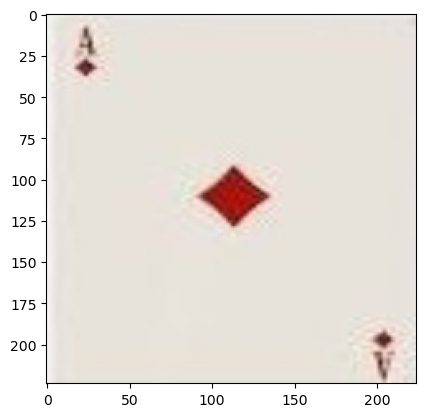

In [37]:
def img(filepath):
    filename = 'Dataset/' + filepath
    image = cv2.imread(filename)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_image

# # NORMALIZATION
# def normalize_img(image):
#     normalized = (img(image) - np.min(img(image)))/(np.max(img(image)) - np.min(img(image)))   
#     return normalized

test_colored_image = 'train/ace of diamonds/112.jpg'
test_img = normalize_img(test_colored_image)
im = test_img

plt.imshow(im)
plt.show()

In [38]:
path_df['image_pixels'] = path_df['filepaths'].apply(img)

In [39]:
path_df.head()

,class_index,filepaths,labels,card_type,data_set,suit,image_pixels
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,clubs,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,clubs,"[[[248, 248, 246], [251, 251, 249], [249, 249,..."
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,clubs,"[[[0, 0, 0], [1, 1, 1], [1, 1, 1], [0, 0, 0], ..."
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,clubs,"[[[252, 255, 255], [252, 255, 255], [252, 252,..."
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,clubs,"[[[254, 255, 253], [253, 255, 250], [253, 254,..."


In [40]:
path_df['image_pixels'][0].shape

(224, 224, 3)

In [41]:
path_df = path_df.drop(columns = ['data_set'])

In [42]:
path_df.head()

,class_index,filepaths,labels,card_type,suit,image_pixels
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,clubs,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,clubs,"[[[248, 248, 246], [251, 251, 249], [249, 249,..."
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,clubs,"[[[0, 0, 0], [1, 1, 1], [1, 1, 1], [0, 0, 0], ..."
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,clubs,"[[[252, 255, 255], [252, 255, 255], [252, 252,..."
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,clubs,"[[[254, 255, 253], [253, 255, 250], [253, 254,..."


## ResNet

In [43]:
image_size = [224, 224]

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size + [3]))

print(base_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [44]:
# Don't want to train model because it is already trained.
for layer in base_model.layers:
    layer.trainable = False

In [45]:
num_class = len(card_suits)
print(num_class)

4


In [50]:
flatten_layer = Flatten()(base_model.output)
prediction  = Dense(53, activation='softmax')(flatten_layer)
model = Model(inputs=base_model.input, outputs=prediction)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [51]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [52]:
train_folder = "/home/diana/w281/ucb_mids_w281_project/Dataset/train"
test_folder = "/home/diana/w281/ucb_mids_w281_project/Dataset/test"
val_folder = "/home/diana/w281/ucb_mids_w281_project/Dataset/valid"

train_data_generator = ImageDataGenerator(rescale = 1. /255,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

test_data_generator = ImageDataGenerator(rescale=1. /255)

training_set = train_data_generator.flow_from_directory(train_folder, target_size=(224,224), batch_size=32, class_mode='categorical')
test_set = test_data_generator.flow_from_directory(val_folder, target_size=(224,224), batch_size=32, class_mode='categorical')


Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [53]:
result = model.fit(training_set, 
                   validation_data=test_set, 
                   epochs=2,
                   steps_per_epoch=len(training_set),
                   validation_steps=len(test_set))

Epoch 1/2
239/239 [==============================] - 275s 1s/step - loss: 7.8675 - accuracy: 0.1657 - val_loss: 5.3236 - val_accuracy: 0.2792
Epoch 2/2
239/239 [==============================] - 289s 1s/step - loss: 5.0946 - accuracy: 0.2838 - val_loss: 5.0558 - val_accuracy: 0.3509


In [ ]:
plt.plot(result.history['accuracy'], label='train_acc')
plt.plot(result.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
path_df.head()

In [ ]:
# Set the desired input size for ResNet
input_size = (224, 224)

# Preprocess the image data
all_images = []
all_labels = []

for idx, row in path_df.iterrows():
    filepath = 'Dataset/' + row['filepaths']
    image = load_img(filepath, target_size=input_size)
    image_array = img_to_array(image)
    all_images.append(image_array)
    all_labels.append(row['labels'])

all_images = np.array(all_images) / 255.0
all_labels = np.array(all_labels)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Perform label encoding on the string labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)

In [ ]:
# Split the data into train, validation, and test sets
X_train, X_test_val, y_train, y_test_val = train_test_split(
    all_images, encoded_labels, test_size=0.2, random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=42
)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Convert the encoded labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(y_train)
val_labels = tf.convert_to_tensor(y_val)
test_labels = tf.convert_to_tensor(y_test)

In [ ]:
# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## ResNet

In [1]:
image_size = [224, 224]

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size + [3]))

print(base_model.summary())

NameError: name 'ResNet50' is not defined

In [ ]:
# Add custom classification layers on top of the pre-trained ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the pre-trained layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 1
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

In [ ]:
# Evaluate the model
model.evaluate(test_dataset)

In [ ]:
# Split the data into features (X) and labels (y)
X = np.array(path_df['image_pixels'])  # Replace 'target_variable_name' with the actual name of your target variable
y = np.array(path_df['suit'])  # Replace 'target_variable_name' with the actual name of your target variable



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Validation set shape:", X_val.shape)

In [ ]:
print(type(X_train))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
print(train_dataset)

In [ ]:
# # Convert 'image_pixels' column to a TensorFlow tensor dataset
# image_dataset = tf.data.Dataset.from_tensor_slices(path_df['image_pixels'].values)

# # Iterate through the dataset
# for tensor in image_dataset:
#     print(tensor)

In [ ]:
# print(type(X_train))
# X_train = tf.convert_to_tensor(np.array(X_train), dtype=tf.float32)
# X_test = tf.convert_to_tensor(np.array(X_train), dtype=tf.float32)
# X_val = tf.convert_to_tensor(np.array(X_train), dtype=tf.float32)
# y_train = tf.convert_to_tensor(np.array(X_train), dtype=tf.float32)
# y_test = tf.convert_to_tensor(np.array(X_train), dtype=tf.float32)
# y_val = tf.convert_to_tensor(np.array(X_train), dtype=tf.float32)

# print(type(X_train))

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [ ]:
# Add custom classification layers on top of the pre-trained ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=1,
    validation_data=(X_val, y_val)
)